# Visual RAG on Refined ChartQA Dataset

In [1]:
from settings import *

## Retrieval with ColPali

Images already stored at /projects/multimodal_bootcamp/multimodal-td-2/shared/chartqa_images/val
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/fs01/home/ws_sabbasi/projects/chartqa_visual_rag/.myvenv/lib/python3.10/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was save

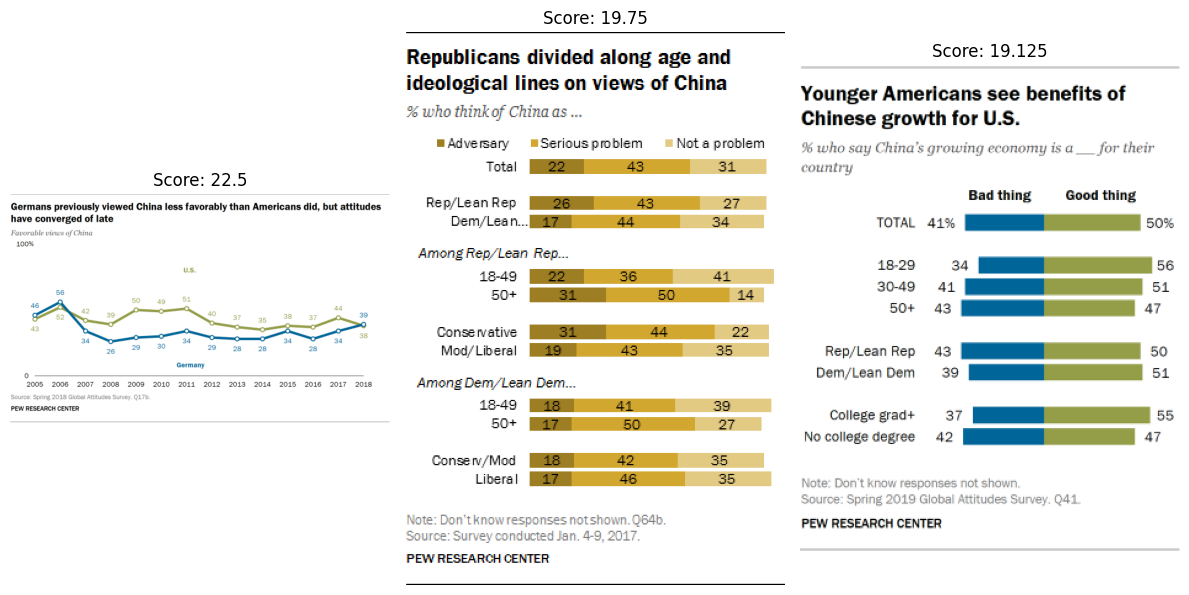

In [2]:
from multi_modal import MultiModalRetriever

ret_model_name = "colpali13"
retriever = MultiModalRetriever(model_name=ret_model_name)

# query = "What was the percentage of favorable views of China among Americans in 2015?"
query = "In which country did the highest favorable view of China reach 56%?"

ret_results = retriever.search(query, verbose=True)

## Generation with Qwen2.5 VLM

In [3]:
from multi_modal import MultiModalGenerator 

gen_model_name = "qwen25_vl_7b_instruct"
generator = MultiModalGenerator(model_name=gen_model_name)

images = [retriever.load_image(res['metadata']['image_name']) for res in ret_results]
gen_result = generator.generate(query, images=images, verbose=True)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


The graph shows that in Germany, the highest favorable view of China reached 56% in 2006. This is indicated by the green line representing Germany's data points, which peaks at 56% in 2006 before declining slightly in subsequent years.


## Sample End-to-end Visual RAG

In [4]:
from datasets import Dataset

refined_path = f"{TEAM_ROOT_DIR}/refined_chartqa/val-100_qwen25_vl_7b_instruct"
refined_dset = Dataset.load_from_disk(refined_path)
refined_dset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine', 'image_id', 'refined_query', 'refined_label'],
    num_rows: 100
})

In [5]:
safe_dset = refined_dset.filter(lambda row: row["label"] == row["refined_label"])
safe_dset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine', 'image_id', 'refined_query', 'refined_label'],
    num_rows: 72
})

In [6]:
import multi_modal
import importlib; importlib.reload(multi_modal)
from multi_modal import MultiModalRAG

rag = MultiModalRAG(retriever=retriever, generator=generator)

Query: Which line on the graph reaches its peak at 56?


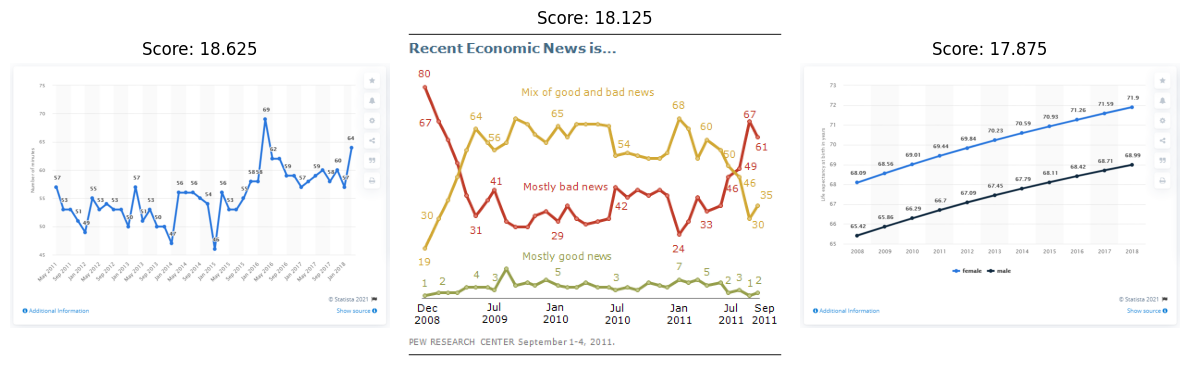

{
  "answer": "The line representing 'Mostly good news' on the second chart reaches its peak at 56.",
  "short_answer": "2",
  "references": [2]
}
GT Answer: Blue
{'ret_precision': 0.0, 'ret_recall': 0.0, 'gen_correctness': 0, 'gen_em': 0.0, 'gen_precision': 0.0, 'gen_recall': 0.0}

Query: What is the highest percentage shown on the blue line in the chart?


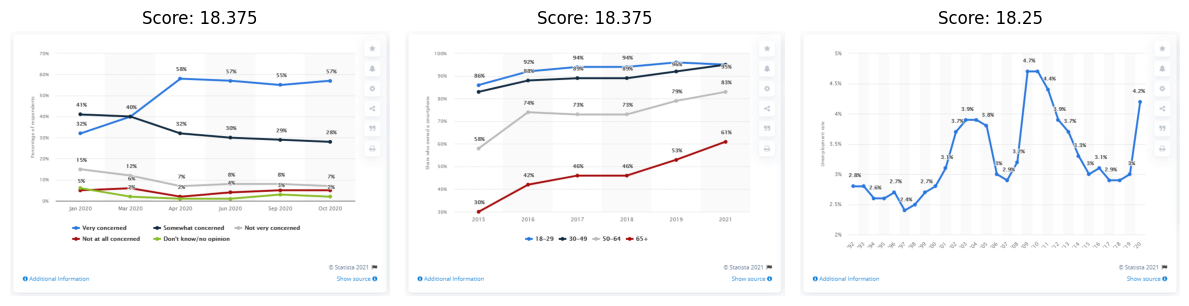

{
  "answer": "The highest percentage shown on the blue line in the chart is 58%. This can be observed by looking at the data points for the 'Very concerned' category in the first chart, where the blue line reaches its peak value of 58% in April 2020.",
  "short_answer": "58%",
  "references": [1]
}
GT Answer: 0.72
{'ret_precision': 0.0, 'ret_recall': 0.0, 'gen_correctness': 0, 'gen_em': 0.0, 'gen_precision': 0.0, 'gen_recall': 0.0}

Query: In 2016, what percentage of respondents said that jobs were a top priority for the president and Congress?


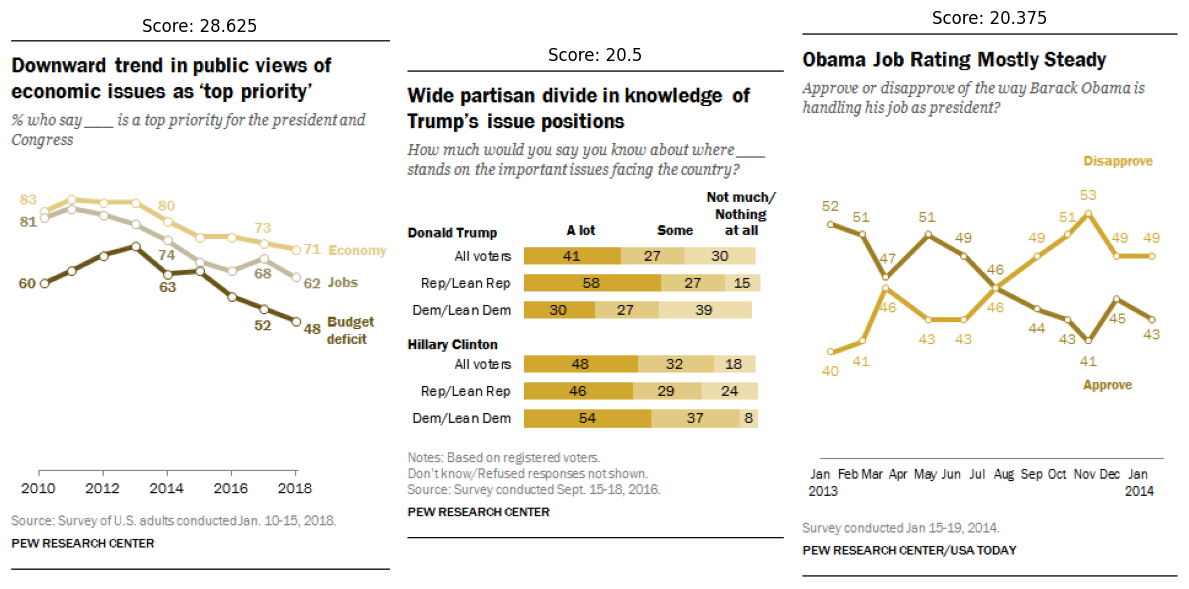

{
  "answer": "According to Chart 1, in 2016, 68% of respondents said that jobs were a top priority for the president and Congress.",
  "short_answer": "68%",
  "references": [1]
}
GT Answer: 68
{'ret_precision': 0.3333333333333333, 'ret_recall': 1.0, 'gen_correctness': 1, 'gen_em': 0.0, 'gen_precision': 1.0, 'gen_recall': 1.0}

Query: In which category did 71% of respondents say was a top priority for the president and Congress?


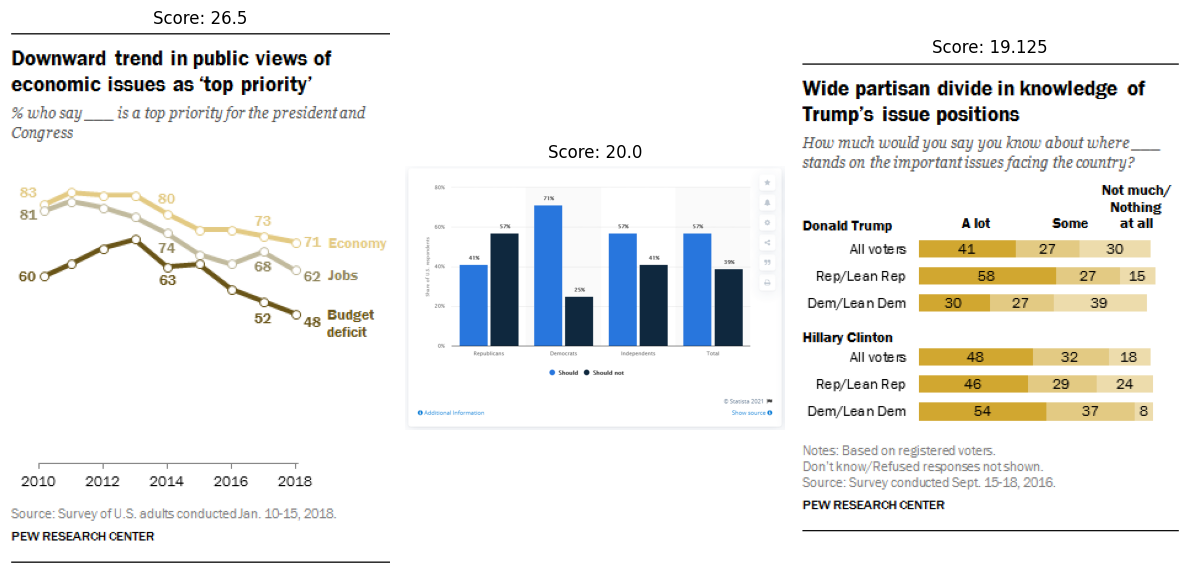

{
  "answer": "The chart shows that 71% of respondents said 'Economy' was a top priority for the president and Congress. This can be observed by looking at the line graph where the 'Economy' line reaches 71% in the year 2018.",
  "short_answer": "Economy",
  "references": [1]
}
GT Answer: Economy
{'ret_precision': 0.3333333333333333, 'ret_recall': 1.0, 'gen_correctness': 1, 'gen_em': 1.0, 'gen_precision': 1.0, 'gen_recall': 1.0}

Query: What percentage of people viewed Ennahda unfavorably in 2014?


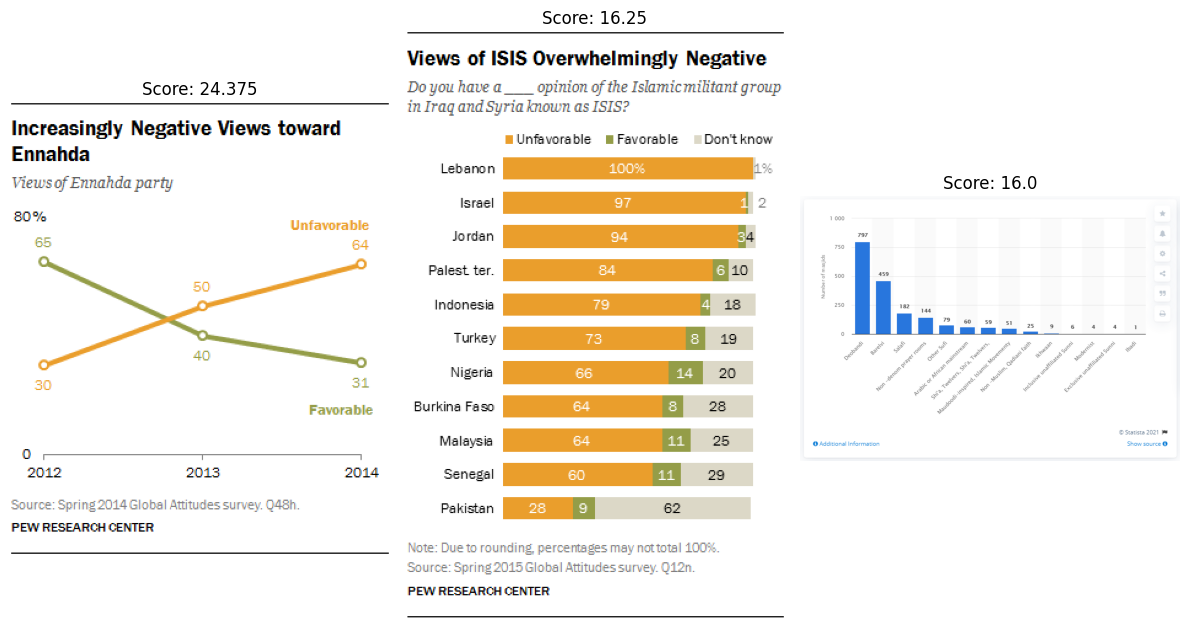

{
  "answer": "In 2014, 64% of people viewed Ennahda unfavorably. This can be seen from Chart 1, which shows the unfavorable views of the Ennahda party over time, with 64% being the value for 2014.",
  "short_answer": "64%",
  "references": [1]
}
GT Answer: 64
{'ret_precision': 0.3333333333333333, 'ret_recall': 1.0, 'gen_correctness': 1, 'gen_em': 0.0, 'gen_precision': 1.0, 'gen_recall': 1.0}

Query: What is the median value of the favorable line in the graph?


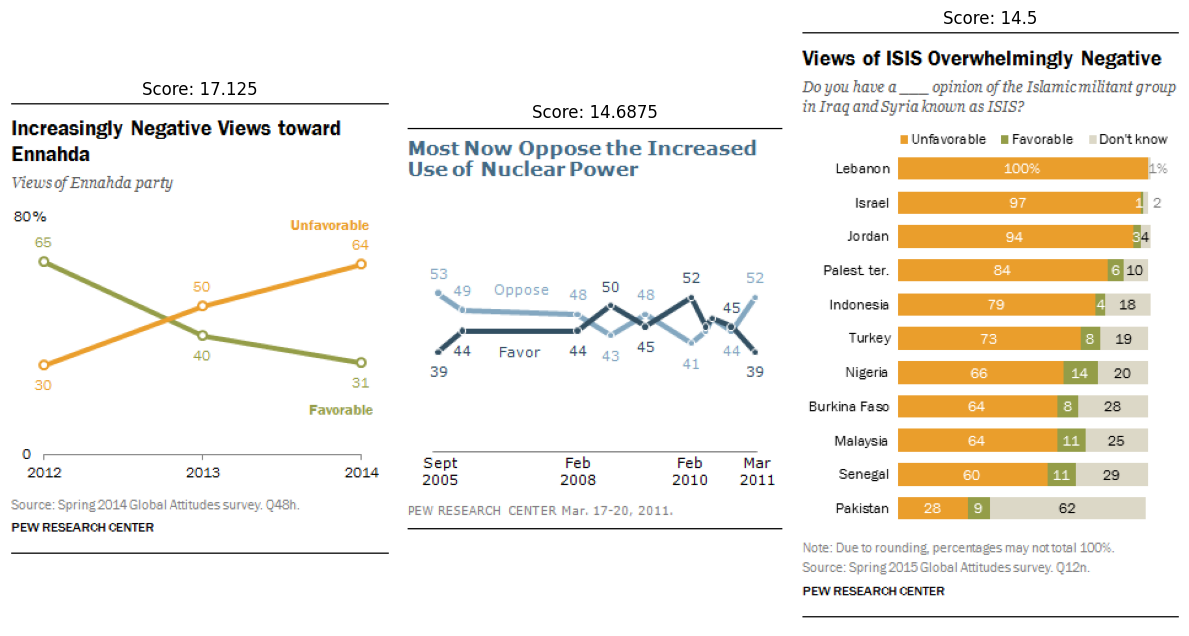

{
  "answer": "The median value of the favorable line in the graph is 45. It can be seen by ordering the values: 39, 44, 45, 48, 48, 49, 50, 52, 52, 53. The middle value is 45.",
  "short_answer": "45",
  "references": [2]
}
GT Answer: 40
{'ret_precision': 0.3333333333333333, 'ret_recall': 1.0, 'gen_correctness': 0, 'gen_em': 0.0, 'gen_precision': 0.0, 'gen_recall': 0.0}

Query: How many times did the percentage of people who disapproved of Barack Obama's job performance exceed 50% during the period shown in the chart?


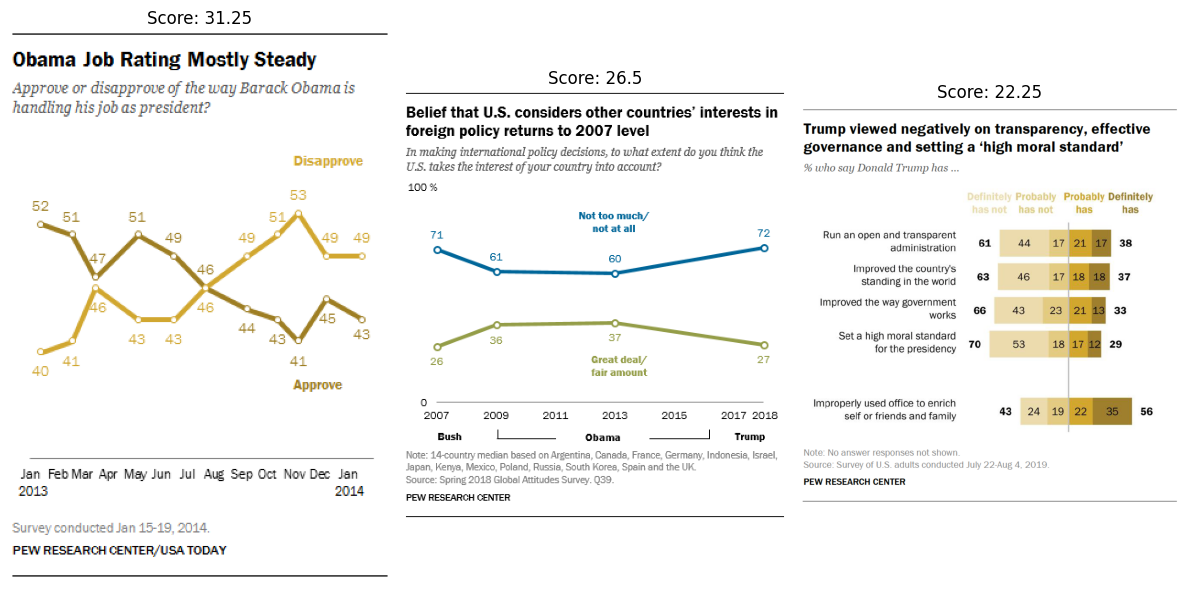

{
  "answer": "The percentage of people who disapproved of Barack Obama's job performance exceeded 50% twice during the period shown in the chart. This can be observed by looking at the 'Disapprove' line on the graph, which shows two instances where the value surpasses 50%. The first instance occurs around April 2013, and the second instance is seen in November 2013.",
  "short_answer": "2",
  "references": [1]
}
GT Answer: 2
{'ret_precision': 0.3333333333333333, 'ret_recall': 1.0, 'gen_correctness': 1, 'gen_em': 1.0, 'gen_precision': 1.0, 'gen_recall': 1.0}

Query: What category consistently shows the lowest percentage throughout the period from December 2008 to September 2011?


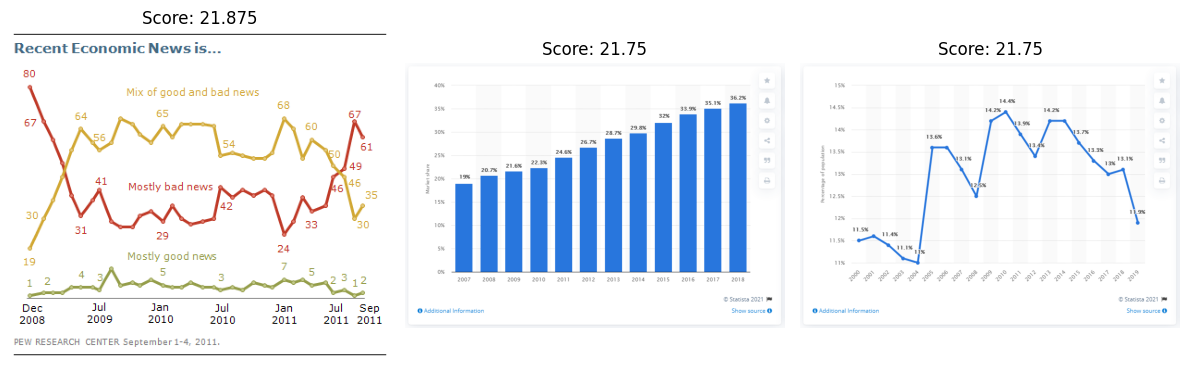

{
  "answer": "The 'mostly good news' category consistently shows the lowest percentage throughout the period from December 2008 to September 2011. The graph indicates that this category remains below the other two categories (mix of good and bad news, mostly bad news) for the entire time frame.",
  "short_answer": "mostly good news",
  "references": [1]
}
GT Answer: Mostly good news
{'ret_precision': 0.3333333333333333, 'ret_recall': 1.0, 'gen_correctness': 1, 'gen_em': 1.0, 'gen_precision': 1.0, 'gen_recall': 1.0}

Query: What was the increase in the percentage of people who said the economic news was mostly bad from January 2011 to September 2011?


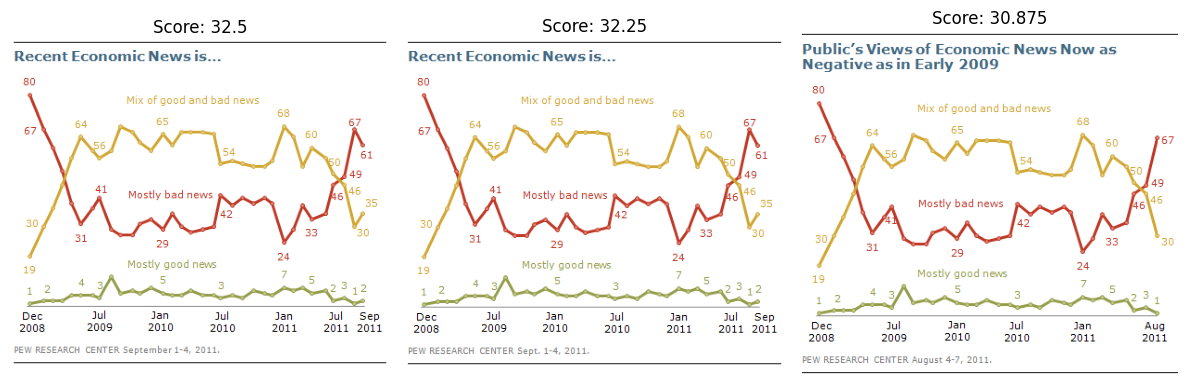

{
  "answer": "The percentage increased by 46%. This can be observed by comparing the value for 'mostly bad news' in January 2011, which was 24%, to the value in September 2011, which was 70%. The difference between these two percentages is 46%.",
  "short_answer": "46%",
  "references": [1, 2, 3]
}
GT Answer: 37
{'ret_precision': 0.3333333333333333, 'ret_recall': 1.0, 'gen_correctness': 0, 'gen_em': 0.0, 'gen_precision': 0.3333333333333333, 'gen_recall': 1.0}

Query: What is the sum of the highest values for each line on the chart?


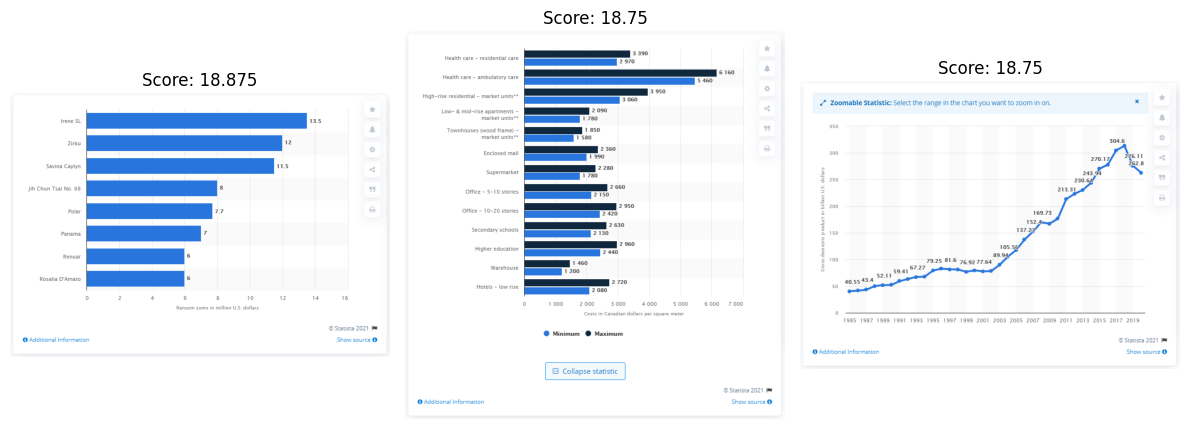

{
  "answer": "The sum of the highest values for each line on the chart is 6160 + 13.5 = 6173.5.",
  "short_answer": "6173.5",
  "references": [1, 2]
}
GT Answer: 155
{'ret_precision': 0.0, 'ret_recall': 0.0, 'gen_correctness': 0, 'gen_em': 0.0, 'gen_precision': 0.0, 'gen_recall': 0.0}



In [7]:
for row in safe_dset.select(range(10)):
    query = row["refined_query"]
    gt_answer = row["refined_label"][0]
    gt_image_id = row["image_id"]
    
    print(f"Query: {query}")
    ret_results, gen_result = rag.run(query=query, verbose=True)
    print(f"GT Answer: {gt_answer}")
    
    metrics = rag.evaluate(query, ret_results, gen_result, gt_image_id, gt_answer)
    print(metrics)
    
    print("=" * 120 + "\n")

# rag._aggregate_metrics()

## End-to-end Visual RAG and Evaluation

In [33]:
from pathlib import Path

rag_metrics = {}
for vlm_name in ["qwen25_vl_7b_instruct", "qwen25_vl_32b_instruct", "qwen25_vl_72b_instruct_awq"]:
    refined_path = f"{TEAM_ROOT_DIR}/refined_chartqa/val-100_{vlm_name}"
    if not os.path.exists(refined_path):
        continue
        
    refined_dset = Dataset.load_from_disk(refined_path)

    safe_dset = refined_dset.filter(lambda row: row["label"] == row["refined_label"])

    # Save the RAG Results
    save_dir = Path(refined_path).parent / f"{Path(refined_path).stem}_rag_results_{ret_model_name}_{gen_model_name}"
    dset, metrics = rag.run_and_evaluate_all(safe_dset, save_dir=save_dir)
    # display(dset)
    # display(metrics)

    run_title = f"{len(safe_dset)} Refined QAs ({vlm_name}) - RAG ({ret_model_name}, {gen_model_name}):"
    rag_metrics[run_title] = metrics

Loading RAG results from /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_7b_instruct_rag_results_colpali13_qwen25_vl_7b_instruct
Loading RAG results from /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_32b_instruct_rag_results_colpali13_qwen25_vl_7b_instruct
Loading RAG results from /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_72b_instruct_awq_rag_results_colpali13_qwen25_vl_7b_instruct


In [34]:
import pandas as pd

metrics_df = pd.DataFrame(rag_metrics).transpose().multiply(100).round(2)
metrics_df

,ret_precision,ret_recall,gen_correctness,gen_em,gen_precision,gen_recall
"72 Refined QAs (qwen25_vl_7b_instruct) - RAG (colpali13, qwen25_vl_7b_instruct):",29.63,88.89,63.89,41.67,87.96,88.89
"86 Refined QAs (qwen25_vl_32b_instruct) - RAG (colpali13, qwen25_vl_7b_instruct):",31.78,95.35,70.93,45.35,91.47,95.35
"95 Refined QAs (qwen25_vl_72b_instruct_awq) - RAG (colpali13, qwen25_vl_7b_instruct):",32.98,98.95,67.37,43.16,94.04,98.95
